<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 4*

# 📝 Assignment
---

# 모델선택(Model Selection)

### 1) 캐글 대회를 이어서 진행합니다. RandomizedSearchCV 를 사용하여 하이퍼파라미터 튜닝을 진행합니다.

- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)를 사용하세요.
- 분류문제에서 맞는 [scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) metric을 사용하세요.
- [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) 사용을 권합니다.
- RandomizedSearchCV 를 사용해서 하이퍼파라미터 튜닝을 진행하고 최고 성능을 보이는 모델로 예측을 진행한 후 캐글에 제출합니다.
- **캐글 Leaderboard에서 개선된 본인 Score를 과제 제출폼에 제출하세요.**

In [44]:
# 분석
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 사이킷런 - 데이터 셋 나누기
from sklearn.model_selection import train_test_split

# 사이킷런 - encoders & imputers
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer, KNNImputer

# 사이킷런 - 파이프라인
from sklearn.pipeline import make_pipeline

# 사이킷런 - 학습모델
from sklearn.ensemble import RandomForestClassifier

# 사이킷런 - 모델 평가 지표
from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score

# 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve

In [46]:
# 데이터 준비 - H1N1백신 관련 데이터

target = 'vacc_h1n1_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [47]:
# features, target 나누기
target = 'vacc_h1n1_f'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[[target]]
X_test = test[features]

In [50]:
def engineer(df):
    
    # Outlier NaN값 처리
    df.loc[df.rent_own_r > 70, 'rent_own_r'] = np.nan

    #NaN값의 개수를 대표하는 num_NaN 생성
    df['num_NaN'] = df.apply(lambda x: x.isna().sum(), axis=1)    

    #쓰지 않는 columns drop
    df = df.drop(['employment_industry', 'employment_occupation', 'state'], axis = 1)

    #behavior_careful 생성
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behavior_careful'] = df[behaviorals].sum(axis=1)

    #heath_care 생성
    df['health_care'] = df['chronic_med_condition'] + df['child_under_6_months'] + df['behavioral_face_mask'] + df['behavioral_wash_hands']
    
    #Ordinal Encoding by NGD
    df.opinion_h1n1_vacc_effective = df.opinion_h1n1_vacc_effective.replace({'Not At All Effective':0, 'Not Very Effective':1, 
         'Dont Know':2, 'Somewhat Effective':3, 'Very Effective':4, 
         'Refused':np.nan}
    )
    df.opinion_seas_vacc_effective = df.opinion_seas_vacc_effective.replace({'Not At All Effective':0, 'Not Very Effective':1, 
         'Dont Know':2, 'Somewhat Effective':3, 'Very Effective':4, 
         'Refused':np.nan}
    )
    df.opinion_h1n1_risk = df.opinion_h1n1_risk.replace({'Very Low':0, 'Somewhat Low':1, 'Dont Know':2, 
         'Somewhat High':3, 'Very High':4, 'Refused':np.nan}
    )
    df.opinion_seas_risk = df.opinion_seas_risk.replace({'Very Low':0, 'Somewhat Low':1, 'Dont Know':2, 
         'Somewhat High':3, 'Very High':4, 'Refused':np.nan}
    )
    df.opinion_h1n1_sick_from_vacc = df.opinion_h1n1_sick_from_vacc.replace({'Not At All Worried':0, 'Not Very Worried':1, 'Dont Know':2, 
         'Somewhat Worried':3, 'Very Worried':4, 'Refused':np.nan}
    )
    df.opinion_seas_sick_from_vacc = df.opinion_seas_sick_from_vacc.replace({'Not At All Worried':0, 'Not Very Worried':1, 'Dont Know':2, 
         'Somewhat Worried':3, 'Very Worried':4, 'Refused':np.nan}
    )
    df.employment_status = df.employment_status.replace({'Unemployed':0, 'Not in Labor Force':1, 'Employed':2}
    )
    df.agegrp = df.agegrp.replace({'6 Months - 9 Years':0, '10 - 17 Years':1, '18 - 34 Years':2, 
         '35 - 44 Years':3, '45 - 54 Years':4, '55 - 64 Years':5, '65+ Years':6})
    df.census_msa = df.census_msa.replace({'Non-MSA':0, 'MSA, Not Principle City':1, 'MSA, Principle City':2})

    return df

In [51]:
# train, test 엔지니어링
train = engineer(train)
test = engineer(test)

In [52]:
# train, validation 나누기
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, train_size = 0.8, random_state=10)

print("train : ", X_train.shape, y_train.shape)
print("validation : ", X_val.shape, y_val.shape)
print("test : ", X_test.shape)

train :  (33723, 38) (33723, 1)
validation :  (8431, 38) (8431, 1)
test :  (28104, 38)


In [53]:
# pipe
pipe = make_pipeline(
      TargetEncoder(min_samples_leaf=1, smoothing=1),
      SimpleImputer(strategy='median'),
      RandomForestClassifier(max_depth = 10, n_jobs=-1, random_state=2)
)
    
parameters = {   
    'randomforestclassifier__max_depth': range(1, 20, 2), 
    'randomforestclassifier__max_features': range(1, 20, 2), 
    'randomforestclassifier__min_samples_leaf' : range(1, 20, 2)
}
    

rf_classifier = RandomizedSearchCV(
    pipe, 
    param_distributions=parameters, 
    n_iter=10, 
    cv=5,
    scoring='accuracy',
    verbose=1,
)

rf_classifier.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y

In [39]:
# RandomCV 결과 확인
print('Best Parameters: ', rf_classifier.best_params_)
print('MAE: ', -rf_classifier.best_score_)

Best Parameters:  {'randomforestclassifier__min_samples_leaf': 9, 'randomforestclassifier__max_features': 19, 'randomforestclassifier__max_depth': 11}
MAE:  -0.8265621189210283


In [58]:
# 가장 최고의 모델로 학습 -> validation dataset score
best_pipe = rf_classifier.best_estimator_

y_pred = best_pipe.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'테스트세트 MAE: ${mae}')

테스트세트 MAE: $0.1875222393547622


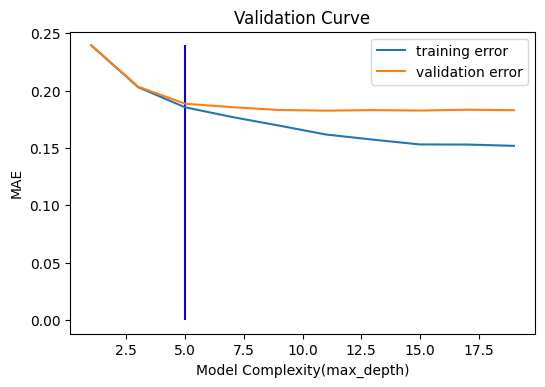

In [67]:
depth = range(1, 20, 2)
ts, vs = validation_curve(
    best_pipe, X_train, y_train
    , param_name='randomforestclassifier__max_depth'
    , param_range=depth, scoring='neg_mean_absolute_error'
    , cv=3
    , n_jobs=-1
)

train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)

fig, ax = plt.subplots()

# 훈련세트 검증곡선
ax.plot(depth, train_scores_mean, label='training error')

# 검증세트 검증곡선
ax.plot(depth, validation_scores_mean, label='validation error')

# 이상적인 max_depth
ax.vlines(5,0, train_scores_mean.max(), color='blue')

# 그래프 셋팅
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(max_depth)', ylabel='MAE')
ax.legend()
fig.dpi = 100

### kaggle제출 (가장 좋았던 모델로 수행)

In [60]:
y_pred_final = best_pipe.predict(X_test)

In [61]:
# 예측값을 제출 form에 저장
sample_submission[target] = y_pred_final
sample_submission

,Id,vacc_h1n1_f
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
28099,28099,0
28100,28100,0
28101,28101,0
28102,28102,0


In [63]:
# 개수 확인 (예측값에서 0, 1 개수 확인)
(y_pred_final == 0).sum(), (y_pred_final == 1).sum()

(23641, 4463)

In [64]:
# 개수 확인 (제출폼 데이터프레임에서 0, 1 개수 확인)
sample_submission[target].value_counts()

0    23641
1     4463
Name: vacc_h1n1_f, dtype: int64

In [65]:
# 저장
sample_submission.to_csv("./submission_dana_randomserachCV.csv", index = False)